#  Import Libraries
- First, we'll import the necessary libraries, such as numpy, pandas, sklearn modules for preprocessing, models, and evaluation metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

import warnings
# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



#  Loading the Datasets
- We load the training and testing datasets using pandas 

In [2]:
# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
1,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
2,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
3,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
4,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
707,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S
708,271,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S
709,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
710,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S


- Dropping irrelevant columns from both train and test datasets

In [3]:
train_df.drop(columns=['Name', 'Cabin', 'Ticket'], inplace=True)
test_df.drop(columns=['Name', 'Cabin', 'Ticket'], inplace=True)

# Checking Null Values
- Checking for null values in both train and test dataset (in percentage)
- remove the rows if percentage is less than 5% in train dataset

In [4]:
null_value_percentages=(train_df.isna().sum()/train_df.shape[0])*100
null_value_percentages

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Sex             0.000000
Age            19.662921
SibSp           0.000000
Parch           0.000000
Fare            0.000000
Embarked        0.280899
dtype: float64

In [5]:
null_value_percentages_2=(test_df.isna().sum()/train_df.shape[0])*100
null_value_percentages_2

PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
Age            5.196629
SibSp          0.000000
Parch          0.000000
Fare           0.000000
Embarked       0.000000
dtype: float64

In [6]:
train_df['Embarked'].isna().sum()

2

In [7]:
columns_with_null_values = null_value_percentages[null_value_percentages>0]
columns_with_null_values

Age         19.662921
Embarked     0.280899
dtype: float64

In [8]:
train_df.shape

(712, 9)

In [9]:
rows_to_drop = null_value_percentages[null_value_percentages < 5].keys()
for row in rows_to_drop:
    if null_value_percentages[row] < 5:
        train_df.drop(labels=train_df.index[train_df[row].isna()], inplace=True)

In [10]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,332,0,1,male,45.5,0,0,28.5000,S
1,734,0,2,male,23.0,0,0,13.0000,S
2,383,0,3,male,32.0,0,0,7.9250,S
3,705,0,3,male,26.0,1,0,7.8542,S
4,814,0,3,female,6.0,4,2,31.2750,S
...,...,...,...,...,...,...,...,...,...
707,107,1,3,female,21.0,0,0,7.6500,S
708,271,0,1,male,NaN,0,0,31.0000,S
709,861,0,3,male,41.0,2,0,14.1083,S
710,436,1,1,female,14.0,1,2,120.0000,S


# Encoding categorical columns with LabelEncoder 
- Sex and Embarked categorical columns are encoded 

In [11]:
le_sex = LabelEncoder()
train_df['Sex'] = le_sex.fit_transform(train_df['Sex'])
unique_op_sex = train_df['Sex'].unique()
print("Label Encoder Parameters Sex", le_sex.inverse_transform(unique_op_sex))

le_embarked = LabelEncoder()
train_df['Embarked'] = le_embarked.fit_transform(train_df['Embarked'])
unique_op_embarked = train_df['Embarked'].unique()
print("Label Encoder Parameters Embarked", le_embarked.inverse_transform(unique_op_embarked))
test_df['Sex'] = le_sex.transform(test_df['Sex'])
test_df['Embarked'] = le_embarked.transform(test_df['Embarked'])

Label Encoder Parameters Sex ['male' 'female']
Label Encoder Parameters Embarked ['S' 'C' 'Q']


In [12]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,332,0,1,1,45.5,0,0,28.5000,2
1,734,0,2,1,23.0,0,0,13.0000,2
2,383,0,3,1,32.0,0,0,7.9250,2
3,705,0,3,1,26.0,1,0,7.8542,2
4,814,0,3,0,6.0,4,2,31.2750,2
...,...,...,...,...,...,...,...,...,...
707,107,1,3,0,21.0,0,0,7.6500,2
708,271,0,1,1,NaN,0,0,31.0000,2
709,861,0,3,1,41.0,2,0,14.1083,2
710,436,1,1,0,14.0,1,2,120.0000,2


# Handling Missing Data
- Handling missing values using KNNImputer for numerical column 'Age' as it is the only column containing null values in both train and test dataset now 

In [13]:
imputer = KNNImputer(n_neighbors=5)
train_df.loc[:, 'Age':] = imputer.fit_transform(train_df.loc[:, 'Age':])
test_df.loc[:, 'Age':] = imputer.transform(test_df.loc[:, 'Age':])

In [14]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,332,0,1,1,45.5,0,0,28.5000,2
1,734,0,2,1,23.0,0,0,13.0000,2
2,383,0,3,1,32.0,0,0,7.9250,2
3,705,0,3,1,26.0,1,0,7.8542,2
4,814,0,3,0,6.0,4,2,31.2750,2
...,...,...,...,...,...,...,...,...,...
707,107,1,3,0,21.0,0,0,7.6500,2
708,271,0,1,1,48.6,0,0,31.0000,2
709,861,0,3,1,41.0,2,0,14.1083,2
710,436,1,1,0,14.0,1,2,120.0000,2


# Outlier detection and removal
- if there are only few outliers remove them , if there are many outliers fit them to the upper whisker and lower whisker

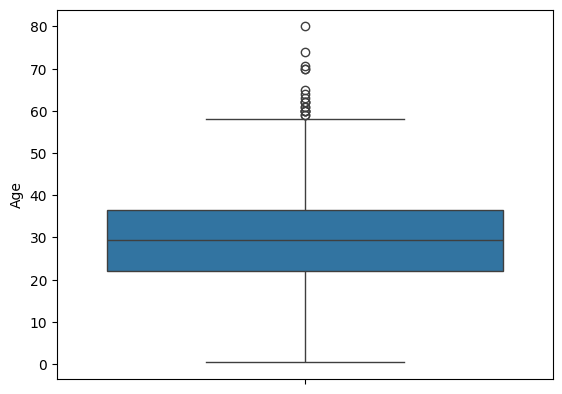

<Figure size 1000x1000 with 0 Axes>

In [15]:
sns.boxplot(train_df["Age"])
plt.figure(figsize=(10, 10))
plt.show()

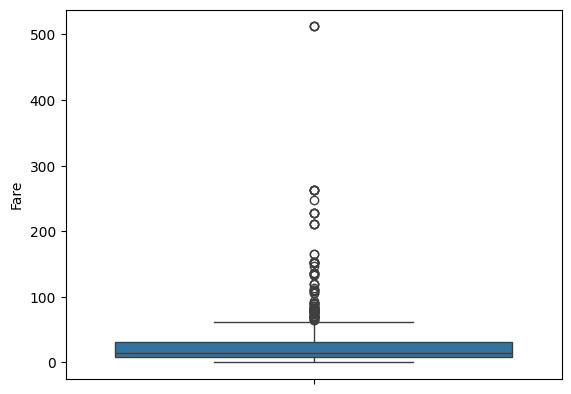

<Figure size 1000x1000 with 0 Axes>

In [16]:
sns.boxplot(train_df["Fare"])
plt.figure(figsize=(10, 10))
plt.show()

- Custom class for handling outliers in Age and Fare columns using IQR method


In [17]:
class OutlierRemoval:
    def __init__(self, col):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        inter_quartile_range = q3 - q1
        self.upper_whisker = q3 + inter_quartile_range * 1.5
        self.lower_whisker = q1 - inter_quartile_range * 1.5

    def remove_outliers(self, df, column_name):
        # Remove rows where the column value is outside the whiskers
        return df[(df[column_name] >= self.lower_whisker) & (df[column_name] <= self.upper_whisker)]

    def fit_to_whisker(self, df, column_name):
        # Fit values greater than the upper whisker to the upper whisker
        # Fit values smaller than the lower whisker to the lower whisker
        df[column_name] = df[column_name].apply(
            lambda x: min(max(x, self.lower_whisker), self.upper_whisker)
        )
        return df


- Removing outliers from 'Age' and fitting 'Fare' to whisker values

In [18]:
remover_age = OutlierRemoval(train_df['Age'])
fit_fare = OutlierRemoval(train_df['Fare'])
train_df = remover_age.remove_outliers(train_df, 'Age')
train_df = fit_fare.fit_to_whisker(train_df, 'Fare')

C:\Users\91630\AppData\Local\Temp\ipykernel_10824\3400995253.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(


In [19]:
train_df.shape

(691, 9)

# Model training setup - Preparing the data

In [20]:
X = train_df.loc[:, 'Pclass':]  # Features
y = train_df['Survived']        # Target variable

# Set up stratified K-fold cross-validation

In [21]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree Classifier with GridSearchCV

In [ ]:
# Define hyperparameter grid for Decision Tree
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    'max_features': ['sqrt', 'log2', None, 0.5, 0.75, 5],
    "min_samples_leaf":list(range(1, 20)), 
}
# Initialize and run GridSearchCV for Decision Tree

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=skfold)
tree_cv.fit(X, y)
best_params = tree_cv.best_params_
# Display best parameters and cross-validation accuracy
print(f"Best paramters: {best_params})")
print("Best Cross-Validation Accuracy:", tree_cv.best_score_)
# Get the best Decision Tree model
best_dtc = tree_cv.best_estimator_


Fitting 5 folds for each of 4332 candidates, totalling 21660 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'best'})
Best Cross-Validation Accuracy: 0.8321238661244916


# Random Forest Classifier with GridSearchCV

In [ ]:
# Define hyperparameter grid for Random Forest
n_estimators = [200,300,500]
max_features = ['sqrt', 'log2']
max_depth = [3, 5]
max_depth.append(None)
min_samples_split = [2, 5]
min_samples_leaf = [2, 4, 5]
bootstrap = [True, False]
params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

# Initialize and run GridSearchCV for Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=skfold, verbose=2, n_jobs=-1)
rf_cv.fit(X, y)
best_params = rf_cv.best_params_
# Display best parameters and cross-validation accuracy
print(f"Best parameters: {best_params}")
print("Accuracy for Random Forest:", rf_cv.best_score_)
# Get the best Random Forest model
best_rf_model = rf_cv.best_estimator_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for Random Forest: 0.8379105411323116


# XGBoost Classifier with GridSearchCV

In [24]:
#Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.08, 0.1, 0.15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.1, 0.15, 0.2]
}

# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)

# Initialize and run GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=xgb_param_grid,
                               scoring='accuracy', cv=skfold, verbose=2, n_jobs=-1)
xgb_grid_search.fit(X, y)
# Display best parameters and cross-validation accuracy
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best Accuracy for XGBoost:", xgb_grid_search.best_score_)
# Get the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters for XGBoost: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Best Accuracy for XGBoost: 0.8452090501511835


- in the above three models , xgboost has the highest accuracy

In [25]:
# Predict using XGBoost model on test dataset
predictions = best_xgb_model.predict(test_df.loc[:, 'Pclass':])

output_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],  # Use 'PassengerId' from the test dataset
    'Survived': predictions                    # Use the predicted 'Survived' values
})

# Save the predictions to a CSV file
output_df.to_csv('xgb.csv', index=False)